In [1]:
import os
import json
import numpy as np
import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# %matplotlib widget
%matplotlib inline

In [2]:
os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'False'

In [3]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd()) + '-lr'
!mkdir -p figures/lr/

Currently running servers:
http://localhost:8888/ :: /home/nazya
1021 (user ID) old priority 19, new priority 19


In [4]:
#del mcolors.TABLEAU_COLORS['tab:pink']
colors = list(mcolors.TABLEAU_COLORS.keys())
markers = ['o', '<', '>', 'v', 's', 'D', '*']
linestyles = [
     ('solid',                 (0, ())),      # Same as (0, ())
     #('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     #('densely dotted',        (0, (1, 1))),
     #('long dash with offset', (5, (10, 3))),
     #('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (3, 3))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [5]:
label_key = 'optimizer'
metric_key = 'dist'

In [6]:
lrs = [1/2/1e3/100, 1/2/1e3/50, 1/2/1e3/25]

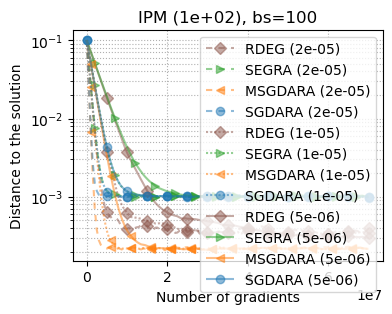

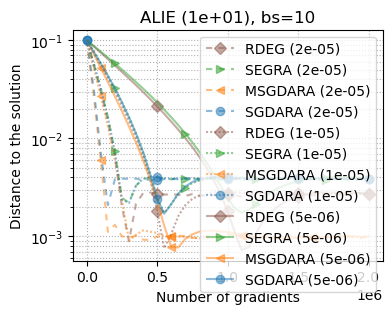

In [7]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
for an, ap, bs, end in [('IPM', 1e2, 100, 7e7), ('ALIE', 1e1, 10, 2e6)]:
    plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack_param'] != ap:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 0
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = '%s (%.e), bs=%i' % (an, ap, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/'+title+'.pdf', bbox_inches='tight')
    plt.show()

In [8]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

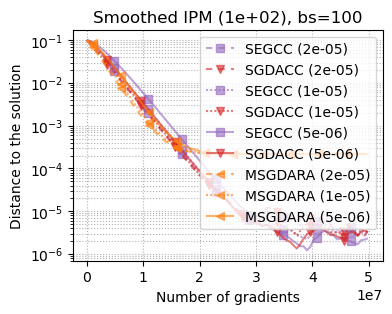

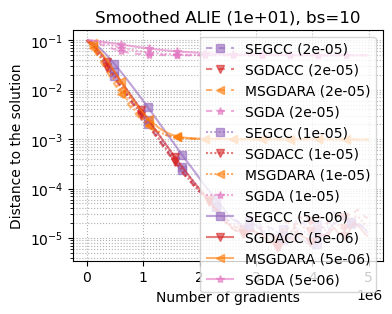

In [9]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
for an, ap, bs, end in [('IPM', 1e2, 100, 5e7), ('ALIE', 1e1, 10, 5e6)]:
    plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack_param'] != ap:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue
        beg = 0
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]

        y = smooth(y, 0.8)

        plt.plot(x, y,
                 alpha=0.6, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = 'Smoothed %s (%.e), bs=%i' % (an, ap, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/cc '+title+'.pdf', bbox_inches='tight')
    plt.show()

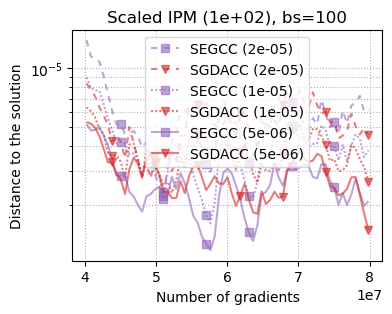

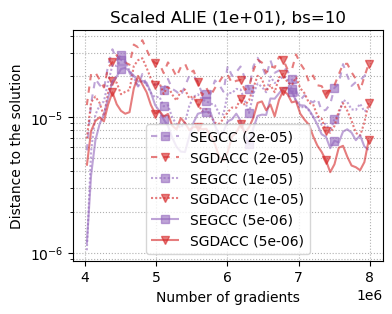

In [10]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
optimizer_names = ['SGDACC', 'SEGCC']
for an, ap, bs, beg, end in [('IPM', 1e2, 100, 4e7, 8e7), ('ALIE', 1e1, 10, 4e6, 8e6)]:
    plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack_param'] != ap:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]

        y = smooth(y, 0.8)


        plt.plot(x, y,
                 alpha=0.6, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = 'Scaled %s (%.e), bs=%i' % (an, ap, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/cc '+title+'.pdf', bbox_inches='tight')
    plt.show()

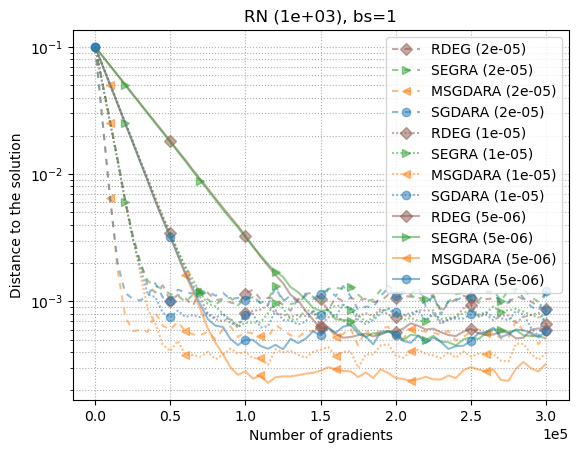

In [18]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
for an, ap, bs, end in [('RN', 1e3, 1, 3e5)]:
    # plt.figure(figsize=(5, 4))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack_param'] != ap:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 0# 2e5
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = '%s (%.e), bs=%i' % (an, ap, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/'+title+'.pdf', bbox_inches='tight')
    plt.show()

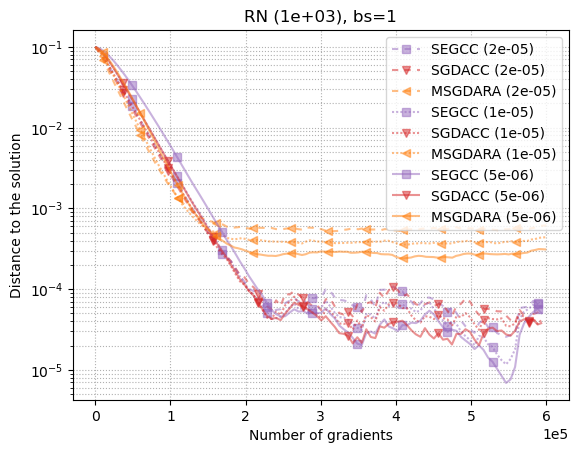

In [16]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
for an, ap, bs, end in [('RN', 1e3, 1, 6e5)]:
    # plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack_param'] != ap:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 0# 2e5
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        
        y = smooth(y, 0.8)
        
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = '%s (%.e), bs=%i' % (an, ap, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/cc '+title+'.pdf', bbox_inches='tight')
    plt.show()

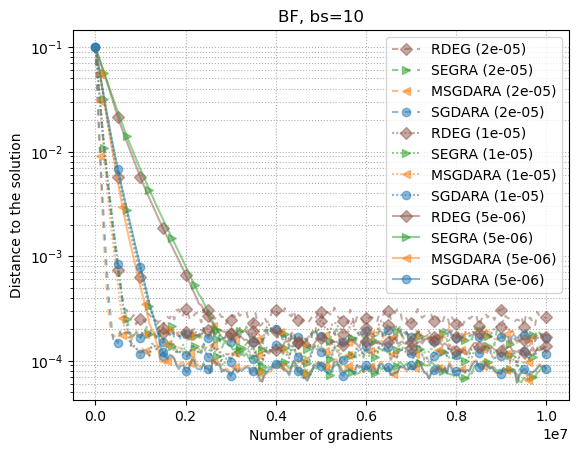

In [19]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
# optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
for an, bs, end in [('BF', 10, 7e7)]:
    # plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 2e6
        beg = 0
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        
        # y = smooth(y, 0.8)
        
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = '%s, bs=%i' % (an, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/'+title+'.pdf', bbox_inches='tight')
    plt.show()

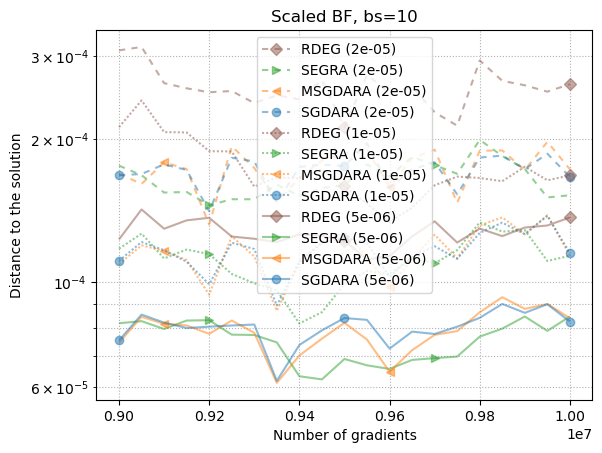

In [20]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
# optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
for an, bs, end in [('BF', 10, 7e7)]:
    # plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 9e6
        # beg = 0
        
        # end = 0.8*1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        
        # y = smooth(y, 0.8)
        
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = 'Scaled %s, bs=%i' % (an, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/'+title+'.pdf', bbox_inches='tight')
    plt.show()

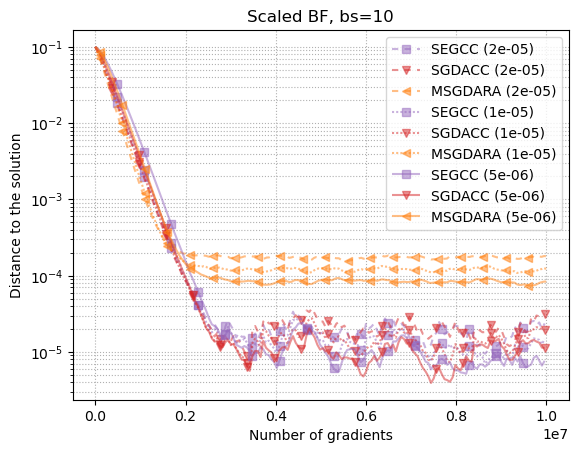

In [21]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGDARA', 'MSGDARA', 'SEGRA', 'RDEG'] #'SGDA']
optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
# optimizer_names = ['SGDA', 'MSGDARA', 'SGDACC', 'SEGCC']
for an, bs, end in [('BF', 10, 7e7)]:
    # plt.figure(figsize=(4, 3))
    for r in runs:
        config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

        if config['batch_size'] != bs:
            continue

        if config['attack']['name'] != an:
            continue

        if config['optimizer']['name'] not in optimizer_names:
            continue

        beg = 9e6
        beg = 0
        
        end = 1e6*bs

        style = lrs.index(config['lr'])

        label = config[label_key]['name']+' (%.e)' % config['lr']
        i = config[label_key]['id']
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        # x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        
        y = smooth(y, 0.8)
        
        plt.plot(x, y,
                 alpha=0.5, color=colors[i],
                 marker=markers[i], markevery=slice(2*i, len(x), 10),
                 label=label, linestyle=linestyles[style][1])

    title = 'Scaled %s, bs=%i' % (an, bs)
    plt.title(title)
    plt.xlabel('Number of gradients')
    plt.ylabel('Distance to the solution')
    plt.yscale('log')
    plt.xscale('linear')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,5))
    plt.grid(True, which="both", ls='dotted')
    plt.legend()
    plt.savefig('figures/lr/'+title+'.pdf', bbox_inches='tight')
    plt.show()